In [4]:
from typing import List, Annotated, Sequence, TypedDict
from dotenv import load_dotenv
load_dotenv()

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
@tool
def add(a: int, b: int) -> int:
    """ this is an additon function that adds 2 numbers """
    return a + b

tools = [add]

model = ChatOpenAI(temperature=0.5, model_name="gpt-3.5-turbo").bind_tools(tools)

def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="""
    You are a helpful assistant that answers my query to the best of your ability.
    """)
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


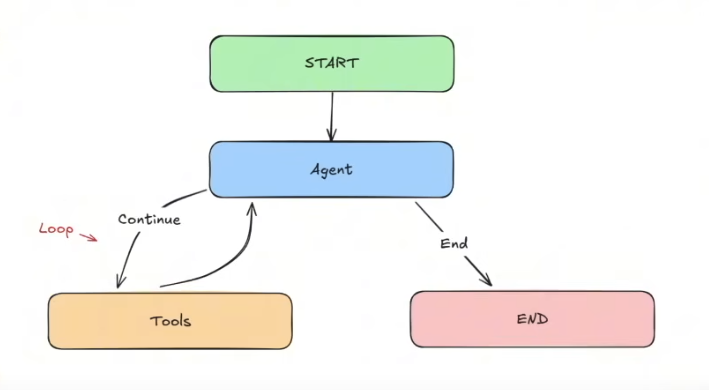

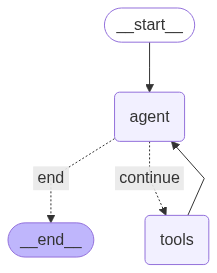

In [7]:
graph = StateGraph(AgentState)

graph.add_node("agent", model_call)
graph.add_edge(START, "agent")

tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {"end": END,
    "continue": "tools"}
)
graph.add_edge("tools", "agent")
app = graph.compile()

from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
app.invoke({"messages": [("user", "Hello, how are you?")]})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='1e46bc73-96bd-4d94-83e7-5b22bdecf985'),
  AIMessage(content="Hello! I'm here and ready to help. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 78, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--aa5b1ecd-cd4c-4c3b-a1fb-d83f8e170b0c-0', usage_metadata={'input_tokens': 78, 'output_tokens': 18, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [10]:
app.invoke({"messages": [("user", "add 40 and 34?")]})

{'messages': [HumanMessage(content='add 40 and 34?', additional_kwargs={}, response_metadata={}, id='3e9a4f1b-f92e-4081-8501-435dfc68cce9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_65Imm0ApPlPSdch1fGs991vm', 'function': {'arguments': '{"a": 40, "b": 34}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 79, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bc6b4ce5-d79e-463a-8c9c-b83c7edfd6ec-0', tool_calls=[{'name': 'add', 'args': {'a': 40, 'b': 34}, 'id': 'call_65Imm0ApPlPSdch1fGs991vm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 79, 'output_tokens': 32, 'total_tok

In [11]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [12]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (call_KvxR9lg3UIGesk07MX35649c)
 Call ID: call_KvxR9lg3UIGesk07MX35649c
  Args:
    a: 40
    b: 12
  add (call_J8lDclDieNQdyCdDGvprJAwk)
 Call ID: call_J8lDclDieNQdyCdDGvprJAwk
  Args:
    a: 52
    b: 0
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  add (call_N4FPuVYOVSrki12Gkpdnv20V)
 Call ID: call_N4FPuVYOVSrki12Gkpdnv20V
  Args:
    a: 52
    b: 0
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================

The sum of 40 + 12 is 52. 

Now, let's multiply 52 by 6: 

52 * 6 = 3